In [2]:
#basic operations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

#trajectory smoothening
from scipy.interpolate import splprep, splev

#deep learning
import tensorflow as tf
import cvnn.layers as complex_layers


In [3]:
# Environment Parameters
epsilon = 1e-10
seed = 42


grid_min, grid_max = 0, 1
step_size = 0.1 # epsilon # distance after which angle changes.
total_time = 10
lookahead = 2
velocity = np.random.uniform(1, 5)
total_distance = velocity * total_time
num_steps = np.floor(total_distance / step_size)
rng = np.random.default_rng()

#x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
#head_dir_initial = math.radians(30)
#print(x_initial, y_initial)

tier_1 = np.arange(-30, 30, 1)
tier_2 = list(range(-60, -30)) + list(range(30, 60))
tier_3 = list(range(-90, -60)) + list(range(60, 90))
num_tries = 10


In [4]:
def get_future_pos(x_current, y_current, head_dir_current):
  x_future = x_current + lookahead * step_size * math.cos(head_dir_current)
  y_future = y_current + lookahead * step_size * math.sin(head_dir_current)
  return x_future, y_future

In [5]:
# Tiered search (random within tiers)
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def choose_head_dir(x_current, y_current, head_dir_current):
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_1)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning slightly")
      return x_future, y_future, head_dir_next

  for _ in range(num_tries):  
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_2)))    
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning diagonally")
      return x_future, y_future, head_dir_next
  
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_3)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min <= x_future <= grid_max and grid_min < y_future < grid_max:
      #print("Turning almost orthagonally")
      return x_future, y_future, head_dir_next
    
  head_dir_next = wrap_angle(head_dir_current + math.radians(180))
  x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
  #print("Taking a U-turn")
  return x_future, y_future, head_dir_next

In [6]:
# Trajectory generation

def generate_trajectory(velocity):
    x_sharp = []
    y_sharp = []
    head_dir = []
    x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
    initial_positions = (x_initial, y_initial)
    head_dir_initial = math.radians(0)
    distance = velocity * total_time
    num_steps = np.floor(distance / step_size)

    for i in range(int(num_steps)):
        if i == 0:
            head_dir_current = head_dir_initial
            x_current, y_current = x_initial, y_initial
            x_sharp.append(x_current)
            y_sharp.append(y_current)
            head_dir.append(head_dir_current)
        
        x_future, y_future, head_dir_next = choose_head_dir(x_current, y_current, head_dir_current)
        x_next = x_current + step_size * math.cos(head_dir_next)
        y_next = y_current + step_size * math.sin(head_dir_next)
        
        head_dir_current = head_dir_next
        x_current, y_current = x_next, y_next

        x_sharp.append(x_current)
        y_sharp.append(y_current)
        head_dir.append(head_dir_current)


    x_sharp = np.array(x_sharp)
    y_sharp = np.array(y_sharp)
    head_dir = np.array(head_dir)
    initial_positions = np.array(initial_positions)
    #print(X.shape, Y.shape, HD.shape, initial_positions.shape)    
    return initial_positions, x_sharp, y_sharp    


In [7]:
# Using Spline function
def generate_smooth_trajectory(velocity):

    initial_positions, x_sharp, y_sharp = generate_trajectory(velocity)
    # s = smoothing factor, larger = smoother
    tck, u = splprep([x_sharp, y_sharp], s=0)
    u_new = np.linspace(0, 1, 1000)  # denser sampling
    x_smooth, y_smooth = splev(u_new, tck)
    return initial_positions, x_smooth, y_smooth

In [8]:
def compute_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)-1):
        dx = x_smooth[i+1] - x_smooth[i]
        dy = y_smooth[i+1] - y_smooth[i]
        #heading_angle = math.atan2(dy, dx)
        norm = np.sqrt(dx**2 + dy**2) + 1e-8
        cos_theta = dx / norm
        sin_theta = dy / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    cos_thetas.append(cos_thetas[-1])  # Repeat last vector to maintain length
    sin_thetas.append(sin_thetas[-1])  # Repeat last vector to maintain length
    return cos_thetas, sin_thetas

In [9]:
# Limb oscillations with curvature

#Parameters

dt = 0.01 # time step
time_series = np.arange(0, total_time, dt)
total_time_steps = len(time_series)

am = 0.1 # stride length
L = 0.05 # length of limb
phi = math.pi #phase difference between contralateral limbs
d = 0.05 # spacing between limb pairs

theta_m = am / (4 * L) # max angle of limb movement
limb_osc_freq = rng.uniform(1, 5) # frequency of limb oscillation
omega = 2 * math.pi * limb_osc_freq # angular frequency

def curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    return (dx * ddy - dy * ddx) / ((dx**2 + dy**2)**1.5 + 1e-8)
    # To avoid division by zero

def limb_oscillations_with_curvature(t, am, L, omega, phi, d, x, y):
    theta_m = am / (4 * L)
    k = curvature(x, y)

    UFL = theta_m * (1 + k*d) * np.sin(omega*t)
    UFR = theta_m * (1 - k*d) * np.sin(omega*t + phi)
    UHR = theta_m * (1 - k*d) * np.sin(omega*t)
    UHL = theta_m * (1 + k*d) * np.sin(omega*t + phi)

    return UFL, UFR, UHR, UHL, k

In [10]:
# Generate 100 trajectories and corresponding limb oscillations

def generate_data(num_trajectories):
    x_smooth_all, y_smooth_all = [], []
    limb_data_all = []
    initial_positions_all = []
    cos_thetas_all, sin_thetas_all = [], []

    for trajectory in range(num_trajectories):
        limb_osc_freq = np.random.uniform(1, 5)
        velocity = am * limb_osc_freq
        omega = 2 * math.pi * limb_osc_freq #angular frequency
        
        initial_positions, x_smooth, y_smooth = generate_smooth_trajectory(velocity)
        cos_thetas, sin_thetas = compute_heading_vectors(x_smooth, y_smooth)
        limb_data = limb_oscillations_with_curvature(time_series, am, L, omega, phi, d, x_smooth, y_smooth)
        
        initial_positions_all.append(initial_positions)
        x_smooth_all.append(x_smooth)
        y_smooth_all.append(y_smooth)
        cos_thetas_all.append(cos_thetas)
        sin_thetas_all.append(sin_thetas)
        limb_data_all.append(limb_data)


    return initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all
    print("Generated", num_trajectories, "trajectories with corresponding limb oscillations.")

initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all = generate_data(100)


In [11]:
initial_positions_all = np.array(initial_positions_all)
x_smooth_all = np.array(x_smooth_all)
y_smooth_all = np.array(y_smooth_all)
limb_data_all = np.array(limb_data_all)
cos_thetas_all = np.array(cos_thetas_all)
sin_thetas_all = np.array(sin_thetas_all)

print(initial_positions_all.shape, x_smooth_all.shape, y_smooth_all.shape, cos_thetas_all.shape, sin_thetas_all.shape, limb_data_all.shape)

(100, 2) (100, 1000) (100, 1000) (100, 1000) (100, 1000) (100, 5, 1000)


In [12]:
traj_data = np.stack((x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all), axis=-1)
traj_data = np.array(traj_data)
print(traj_data.shape) # (100, 1000, 2)

gait_data = limb_data_all.transpose(0, 2, 1)  # (num_trajectories, time_steps, 4 limbs + curvature)
print(gait_data.shape) # (100, 1000, 5)
gait_data_without_curvature = gait_data[:, :, :4]
print(gait_data_without_curvature.shape) #(100, 1000, 4)

initial_positions_all_expanded = np.repeat(initial_positions_all[:, :, np.newaxis], 1000, axis=2)
print(initial_positions_all_expanded.shape)  # (100, 2, 1000)
initial_positions_transpose = initial_positions_all_expanded.transpose(0, 2, 1)
print(initial_positions_transpose.shape)  # (100, 1000, 2)

gait_data_with_initial_pos = np.concatenate((initial_positions_transpose, gait_data_without_curvature), axis=2)
print(gait_data_with_initial_pos.shape) # (100, 1000, 6)

(100, 1000, 4)
(100, 1000, 5)
(100, 1000, 4)
(100, 2, 1000)
(100, 1000, 2)
(100, 1000, 6)


In [13]:
X = gait_data_with_initial_pos
Y = {'pos': traj_data[:, :, :2], 'hd': traj_data[:, :, 2:]}

print(X.shape, len(Y), Y['pos'].shape, Y['hd'].shape)

(100, 1000, 6) 2 (100, 1000, 2) (100, 1000, 2)


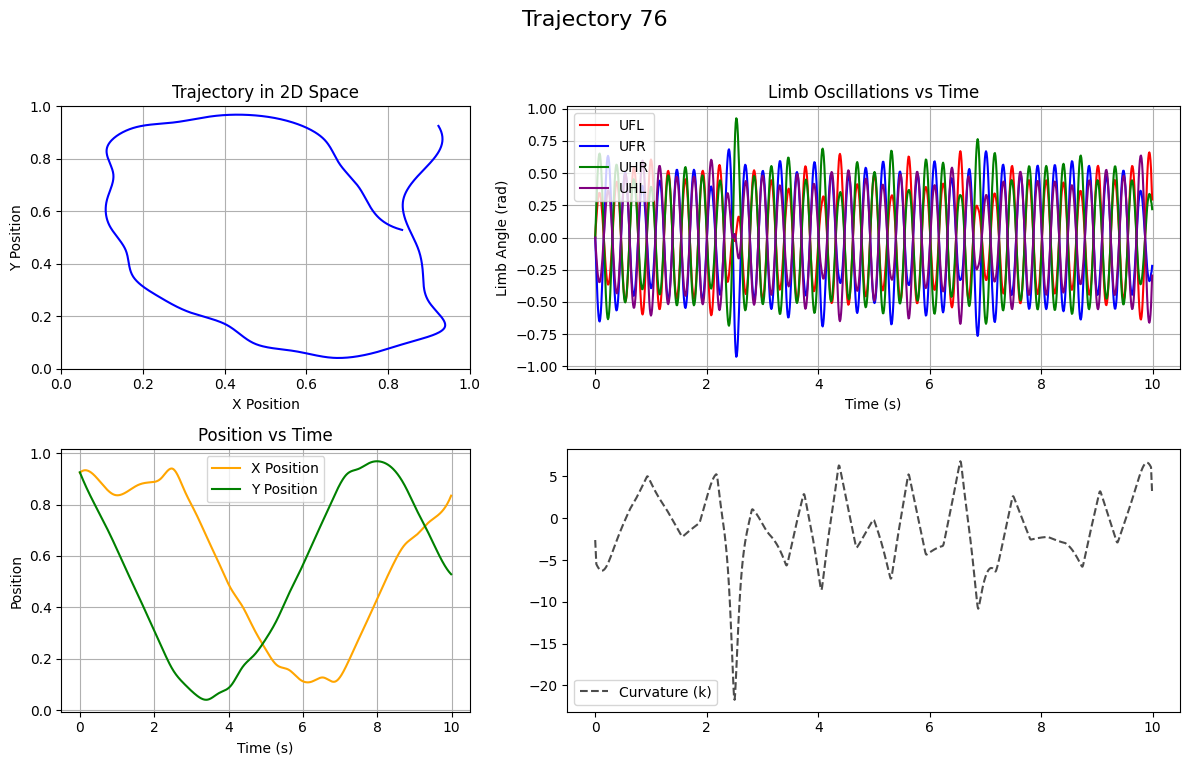

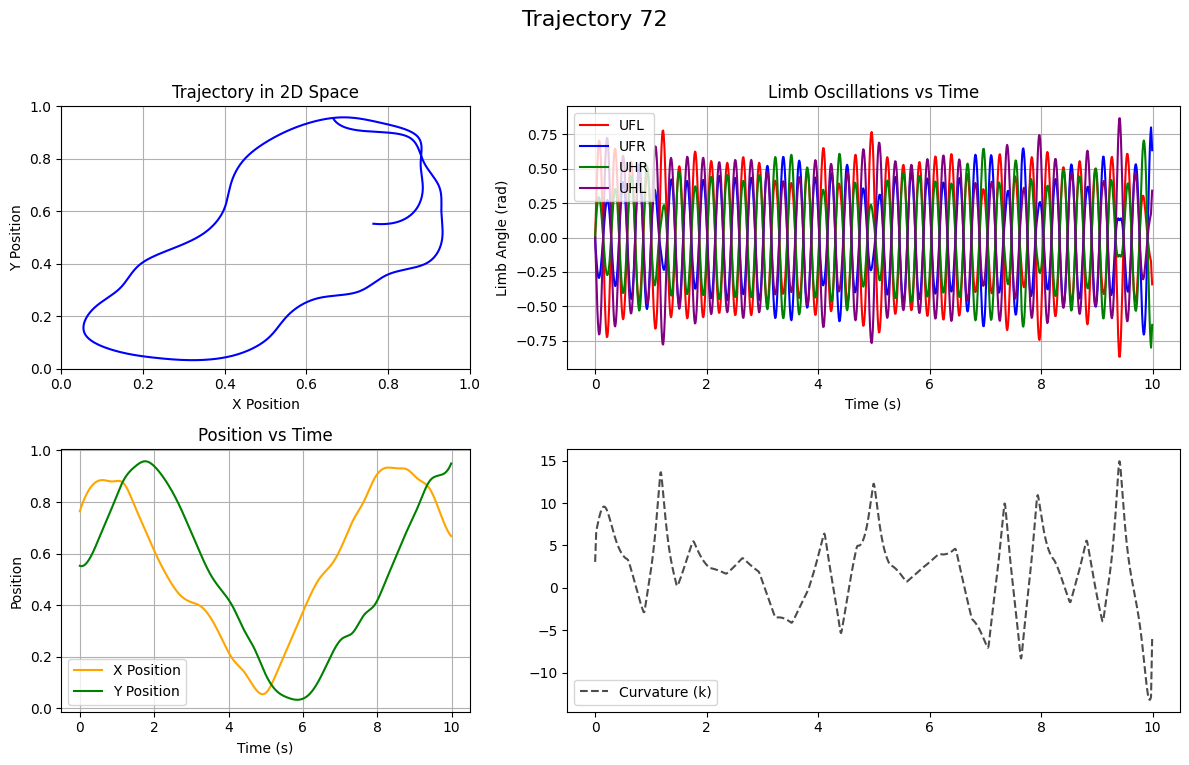

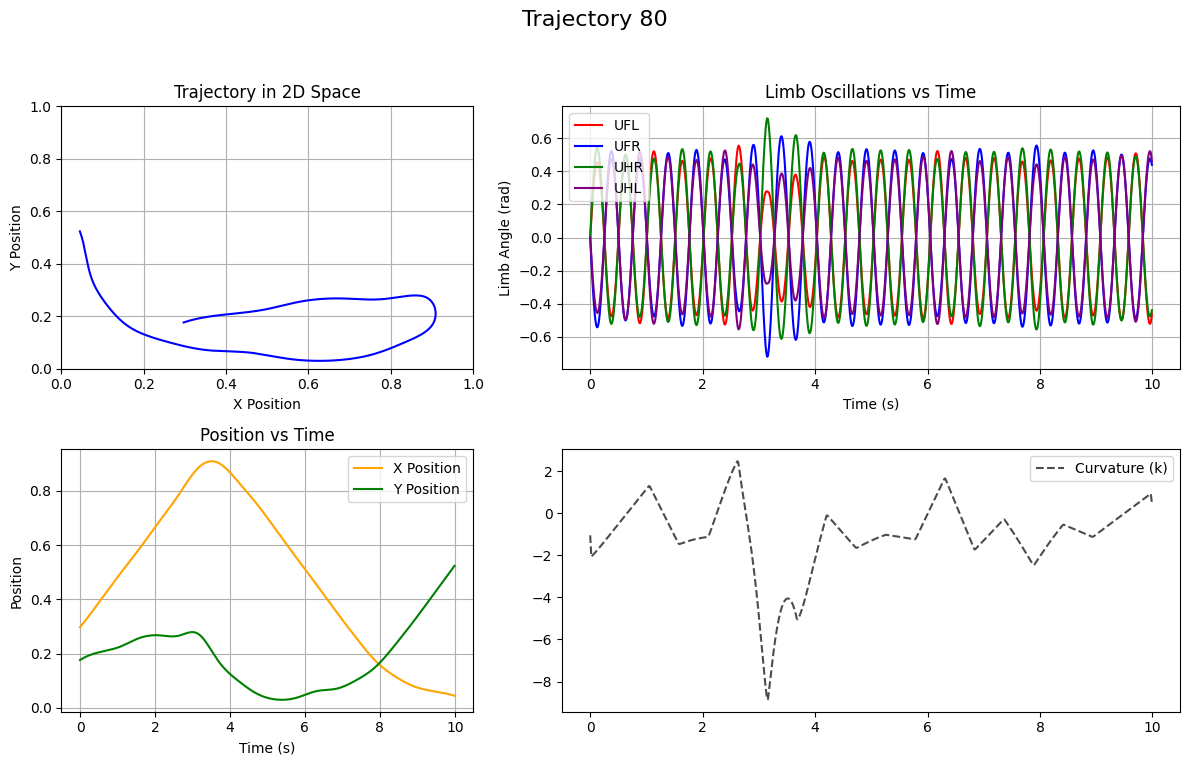

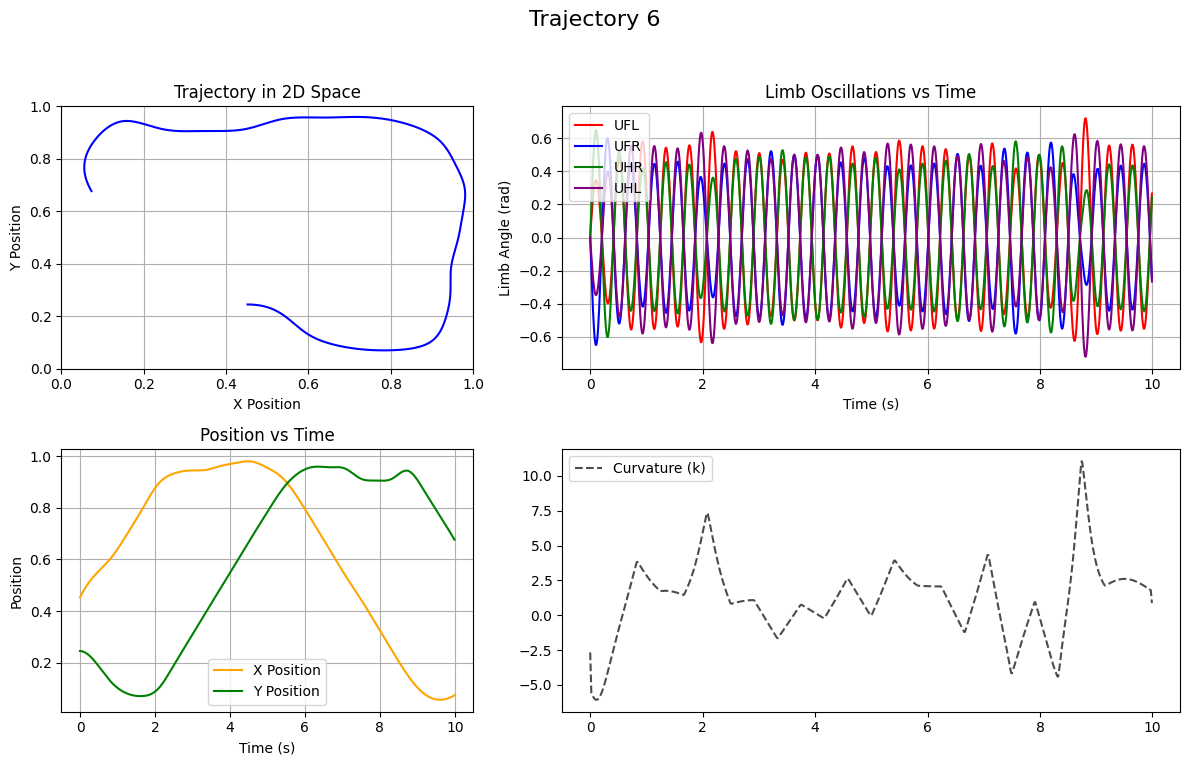

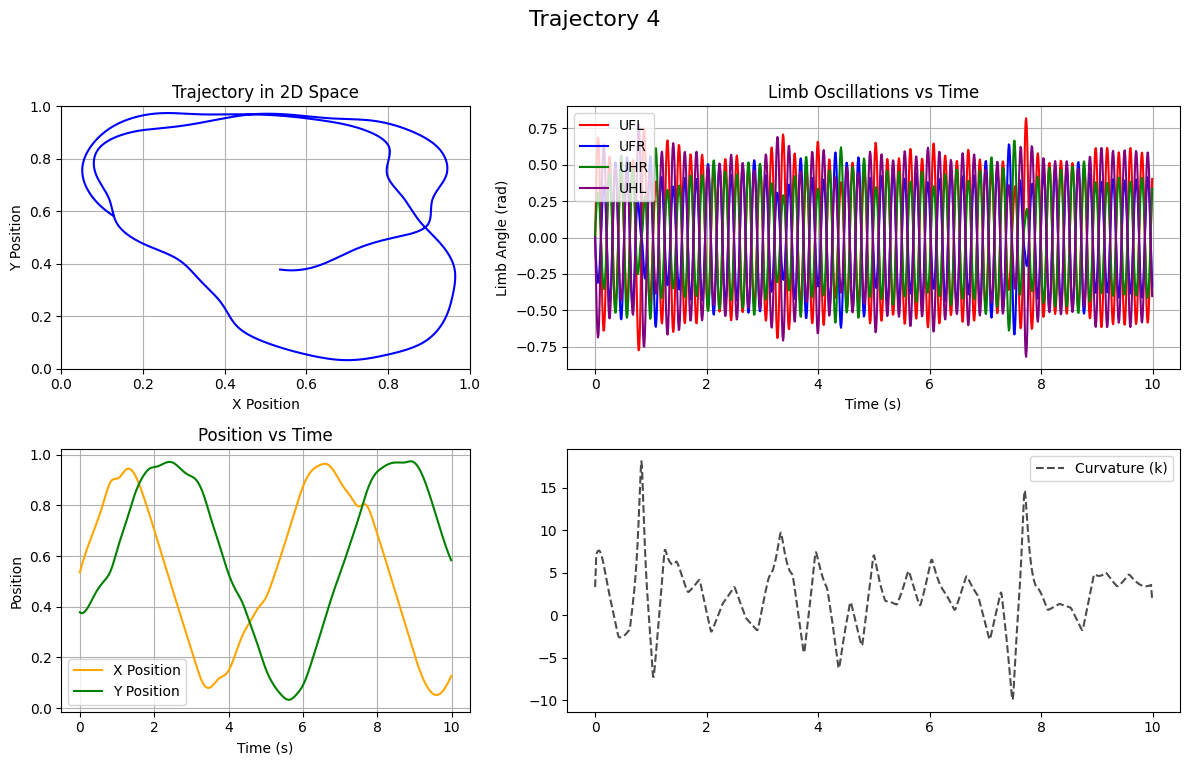

In [14]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    x_traj = x_smooth_all[traj_index]
    y_traj = y_smooth_all[traj_index]
    limb_data_traj = limb_data_all[traj_index]
    UFL_traj, UFR_traj, UHR_traj, UHL_traj, k_traj = limb_data_traj

    # Time vector
    t = time_series[:len(x_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(x_traj, y_traj, color='blue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, x_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, y_traj, label='Y Position', color='green')
    #axes[1, 0].plot(t, head_direction_traj[:len(t)], label='Head Direction', color='purple', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL_traj[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR_traj[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR_traj[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL_traj[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k_traj[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    #ax_bottom_right.set_ylim(-30, 30)
    ax_bottom_right.legend()
    #ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [15]:
# Hopf Oscillator 

@tf.function
def real_cal(r, phi):
    return r * tf.math.cos(phi)

@tf.function
def imag_cal(r, phi):
    return r * tf.math.sin(phi)

@tf.function
#X_r and X_i are input signals, omegas are angular frequencies, num_steps = number of steps
def oscillator_loop(X_r, X_i, omegas, num_steps):
    #r_arr and phi_arr store the evolving values of r (magnitude) and phi (phase angle)
    r_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    phi_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    #Initialising r and phi
    r_t = tf.ones((tf.shape(X_r)[0], tf.shape(X_r)[-1]))
    phis = tf.zeros((tf.shape(X_r)[0], tf.shape(X_r)[-1]))
    #phis = tf.random.uniform((tf.shape(X_r)[0], tf.shape(X_r)[-1]), minval=-5.0, maxval=5.0)
    dt = 0.01
    input_scaler = 10

    for t in tf.range(num_steps):
        input_r = input_scaler*X_r[:,t,:]*tf.math.cos(phis)
        input_phi = input_scaler*X_i[:,t,:]*tf.math.sin(phis)
        r_t = r_t + ((1 - 1*tf.square(r_t)) * r_t + input_r) * dt
        phis = phis + (omegas - input_phi) * dt
        r_arr = r_arr.write(r_arr.size(), r_t)
        phi_arr = phi_arr.write(phi_arr.size(), phis)
    r_arr = tf.transpose(r_arr.stack(), [1, 0, 2])
    phi_arr = tf.transpose(phi_arr.stack(), [1, 0, 2])
    return r_arr, phi_arr

class Hopf(tf.keras.layers.Layer):

    def __init__(self, units, num_steps, min_f=0.1,
                 max_f=10.1, **kwargs):
        super(Hopf, self).__init__(**kwargs)
        self.units = units
        self.num_steps = num_steps
        self.omegas = tf.linspace(min_f, max_f, self.units) * (2*math.pi)
        #Min and max angular freqs. of the oscillators
        self.omegas = tf.cast(tf.expand_dims(self.omegas, 0), 'float32')

    def call(self, z_complex):
        X_r = tf.math.real(z_complex)
        X_i = tf.math.imag(z_complex)
        r, phi = oscillator_loop(X_r, X_i, self.omegas, self.num_steps)
        z_real = real_cal(r, phi)
        z_imag = imag_cal(r, phi)
        return tf.complex(z_real, z_imag)

In [ ]:
# Complex DONN

class Model(tf.keras.Model):

    def __init__(self, units, duration, **kwargs):

        super(Model, self).__init__(**kwargs)

        # Hidden Layers
        self.d1 = complex_layers.ComplexDense(units, activation='cart_relu')
        self.osc1 = Hopf(units, num_steps=duration, min_f=1, max_f=5)
        self.d2 = complex_layers.ComplexDense(units, activation='cart_relu')
        self.osc2 = Hopf(units, num_steps=duration, min_f=4, max_f=8)
        self.d3 = complex_layers.ComplexDense(units, activation='cart_relu')
        self.osc3 = Hopf(units, num_steps=duration, min_f=8, max_f=10)
        self.d4 = complex_layers.ComplexDense(units, activation='cart_relu')
        
        # Output layer
        self.pos_out = tf.keras.layers.Dense(2, activation='sigmoid') # For (x, y)
        self.hd_out = tf.keras.layers.Dense(2, activation='tanh')  # For (cosθ, sinθ)
        #self.out_dense = tf.keras.layers.Dense(4, activation='linear')
        
        
    def build(self, input_shape):
        self.built = True

    def call(self, X):

        X_c = tf.complex(X, tf.zeros_like(X))

        d1 = self.d1(X_c) 
        self.d1_out = d1
        z1 = self.osc1(d1)     
        self.z1_out = z1
        d2 = self.d2(z1)
        self.d2_out = d2
        z2 = self.osc2(d2)
        self.z2_out = z2
        d3 = self.d3(z2)
        self.d3_out = d3
        z3 = self.osc3(d3)
        self.z3_out = z3
        d4 = self.d4(z3)
        self.d4_out = d4
        #dense1_mag = tf.math.abs(dense1) 
        d4_concat = tf.concat([tf.math.real(d4), tf.math.imag(d4)], axis=-1)
        
        pos_out = self.pos_out(d4_concat)
        hd_out = self.hd_out(d4_concat)
        #xy_pos = out_final[:, :, :2]      # (x, y)
        #hd_vec = out_final[:, :, 2:]   # (cosθ, sinθ)
        hd_norm = hd_out / (tf.norm(hd_out, axis=-1, keepdims=True) + 1e-8)

        #out_final = tf.concat([pos_out, hd_norm], axis=-1)
        return {'pos': pos_out, 'hd': hd_norm}

In [17]:
def custom_hd_loss(hd_true, hd_pred, alpha=1.0, beta=0.5):
    
    # cosine similarity loss
    hd_true = hd_true / (tf.norm(hd_true, axis=-1, keepdims=True) + 1e-8)
    hd_pred = hd_pred / (tf.norm(hd_pred, axis=-1, keepdims=True) + 1e-8)
    cos_sim = tf.reduce_sum(hd_true * hd_pred, axis=-1)
    cos_sim_loss = 1.0 - tf.reduce_mean(cos_sim)

    # Circle penalty: (cos^2 + sin^2 - 1)^2
    circle_loss = tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(hd_pred), axis=-1) - 1.0))

    return alpha * cos_sim_loss + beta * circle_loss


In [18]:
model = Model(units = 100,duration= total_time_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# default learning rate = 0.001

model.compile(optimizer=optimizer, 
              loss={"pos":tf.keras.losses.mean_squared_error, "hd":custom_hd_loss}, 
              loss_weights={'pos':1.0, 'hd':1.0})

num_trajectories = X.shape[0]
num_features = X.shape[-1]  # Ensure this matches the input features
dummy_input = tf.zeros((num_trajectories, total_time_steps, num_features))  # Batch size = 100 (example)
_ = model(dummy_input)

2025-10-03 15:00:21.251127: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
model.fit(X,Y, epochs=300, batch_size=20, validation_split=0.2, callbacks=[])

Epoch 1/300
4/4 [==============================] - 6s 2s/step - loss: 1.0688 - hd_loss: 0.9388 - pos_loss: 0.1300 - val_loss: 1.0368 - val_hd_loss: 0.9102 - val_pos_loss: 0.1265
Epoch 2/300
4/4 [==============================] - 8s 2s/step - loss: 1.0226 - hd_loss: 0.8975 - pos_loss: 0.1251 - val_loss: 1.0070 - val_hd_loss: 0.8863 - val_pos_loss: 0.1207
Epoch 3/300
4/4 [==============================] - 6s 2s/step - loss: 0.9836 - hd_loss: 0.8632 - pos_loss: 0.1204 - val_loss: 0.9837 - val_hd_loss: 0.8667 - val_pos_loss: 0.1170
Epoch 4/300
4/4 [==============================] - 6s 1s/step - loss: 0.9565 - hd_loss: 0.8388 - pos_loss: 0.1177 - val_loss: 0.9664 - val_hd_loss: 0.8511 - val_pos_loss: 0.1153
Epoch 5/300
4/4 [==============================] - 6s 1s/step - loss: 0.9257 - hd_loss: 0.8105 - pos_loss: 0.1152 - val_loss: 0.9503 - val_hd_loss: 0.8374 - val_pos_loss: 0.1129
Epoch 6/300
4/4 [==============================] - 7s 2s/step - loss: 0.8964 - hd_loss: 0.7838 - pos_loss: 0.1

In [ ]:
model.save_weights('saved_weights/2d_weights_head_dir_pred.h5')

In [19]:
model.load_weights('saved_weights/2d_weights_custom_loss_300epochs.h5')
predictions = model.predict(X[:, :, :])
print(predictions.shape)

ValueError: Layer count mismatch when loading weights from file. Model expected 6 layers, found 5 saved layers.

In [28]:
predictions[:, :, 0].shape

(100, 1000)

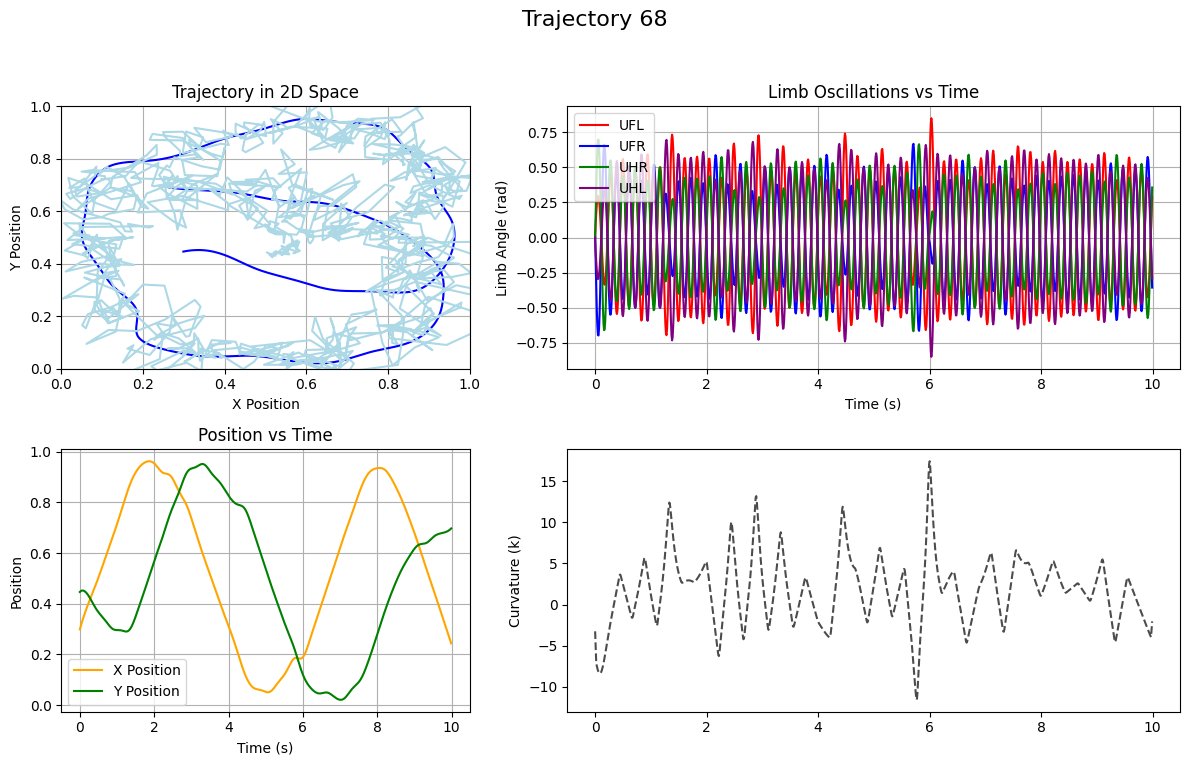

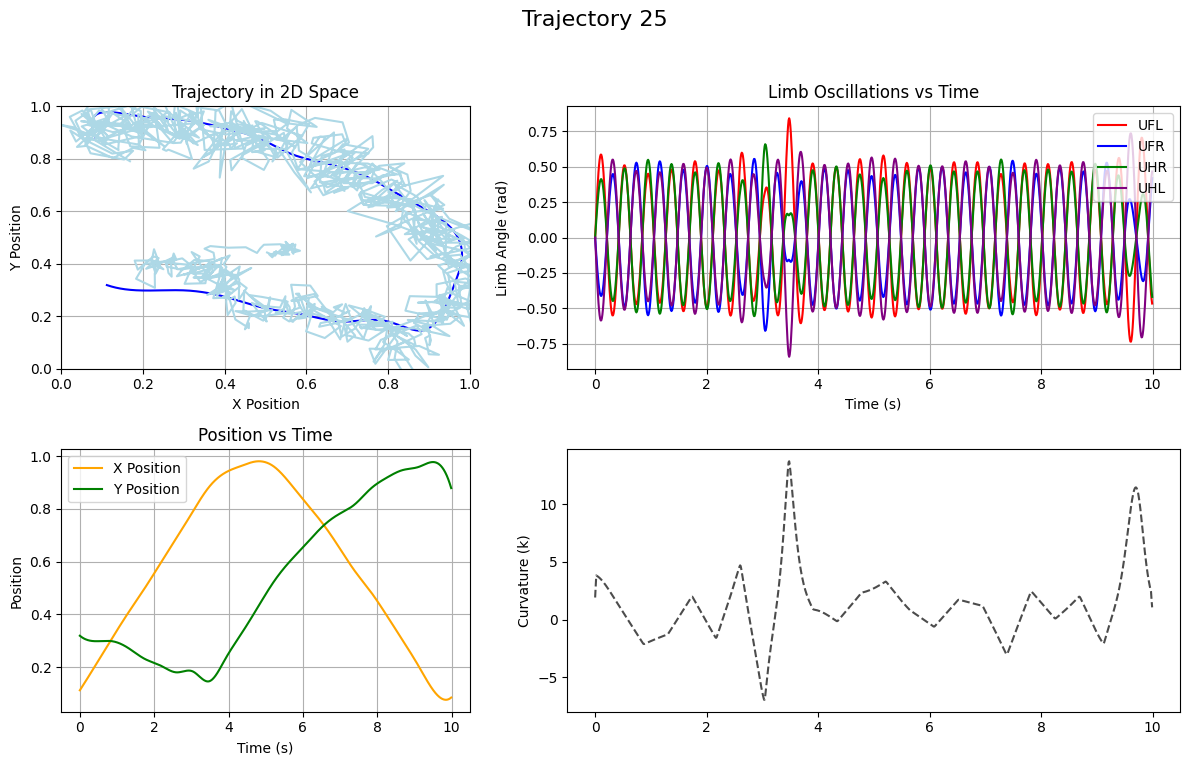

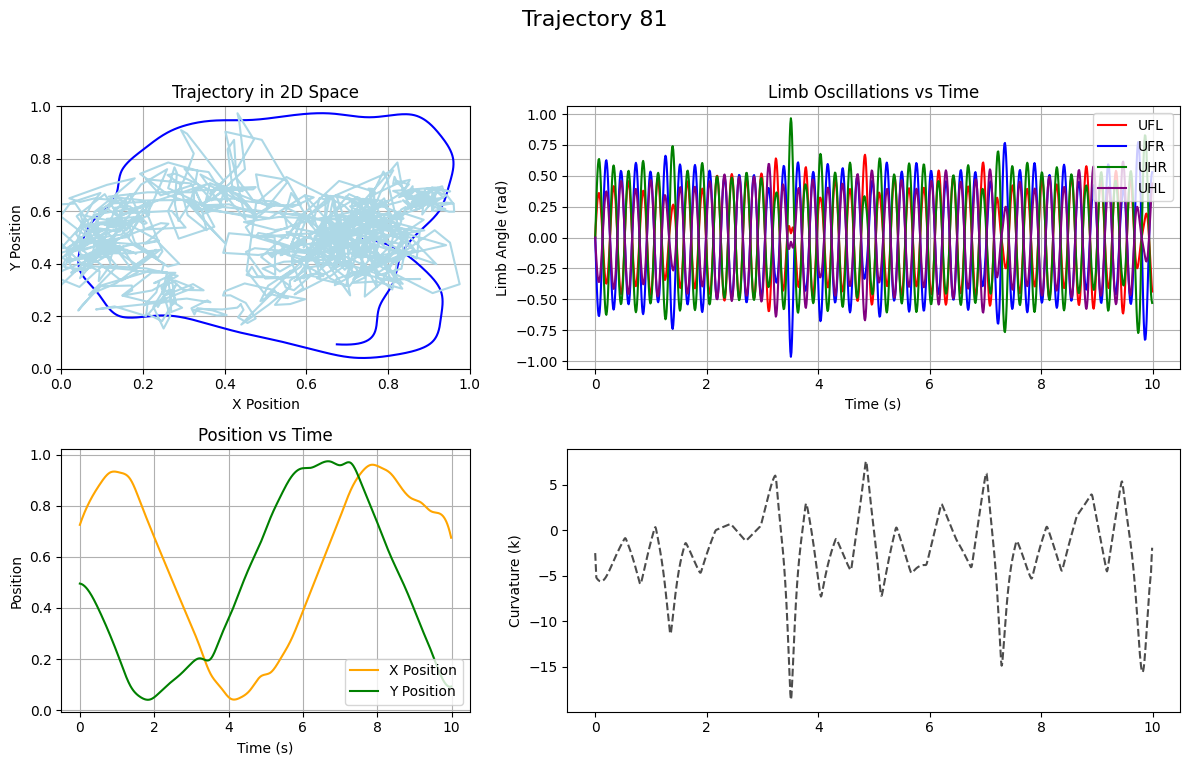

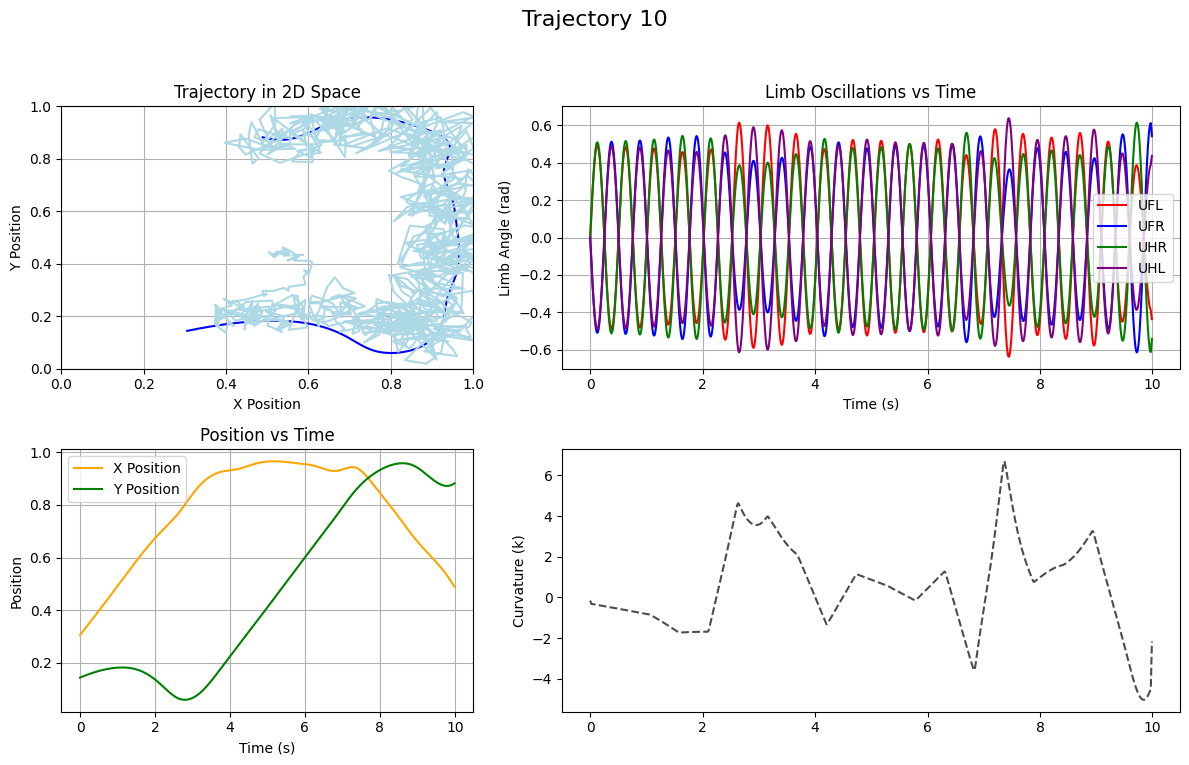

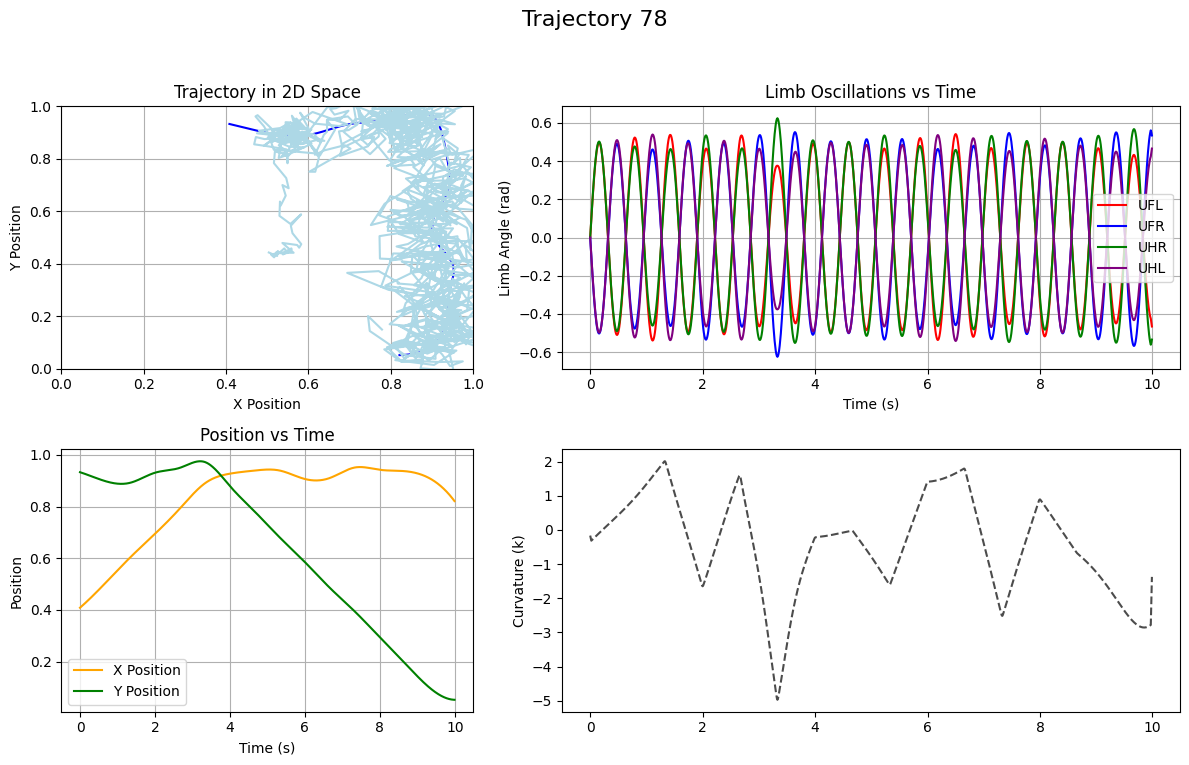

In [35]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    X_traj = x_smooth_all[traj_index]
    Y_traj = y_smooth_all[traj_index]
    limb_data_traj = limb_data_all[traj_index]
    UFL, UFR, UHR, UHL, k = limb_data_traj

    # Time vector
    t = time_series[:len(X_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(X_traj, Y_traj, color='blue')
    axes[0, 0].plot(predictions[traj_index, :, 0], predictions[traj_index, :, 1], color='lightblue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, X_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, Y_traj, label='Y Position', color='green')
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
